# CSE 252B: Computer Vision II, Winter 2025 – Assignment 5


Instructor: Ben Ochoa

Assignment due: Wed, Mar 20, 11:59 PM

**Name: Xiao Nan**

**PID: A69027384**

## Instructions
* Review the academic integrity and collaboration policies on the course
website.
* This assignment must be completed individually.
* All solutions must be written in this notebook.
* Math must be done in Markdown/$\LaTeX$.
* You must show your work and describe your solution.
* Programming aspects of this assignment must be completed using Python in this notebook.
* Your code should be well written with sufficient comments to understand, but there is no need to write extra markdown to describe your solution if it is not explictly asked for.
* This notebook contains skeleton code, which should not be modified (this is important for standardization to facilate efficient grading).
* You may use python packages for basic linear algebra, but you may not use functions that directly solve the problem. If you are uncertain about using a specific package, function, or method, then please ask the instructional staff whether it is allowable.
* **You must submit this notebook as an .ipynb file, a .py file, and a .pdf file on Gradescope.**
    - You may directly export the notebook as a .py file.  You may use [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) to convert the .ipynb file to a .py file using the following command
    `jupyter nbconvert --to script filename.ipynb`
    - There are two methods to convert the notebook to a .pdf file.
        - You may first export the notebook as a .html file, then print the web page as a .pdf file.
        - If you have XeTeX installed, then you may directly export the notebook as a .pdf file.  You may use [nbconvert](https://nbconvert.readthedocs.io/en/latest/install.html) to convert a .ipynb file to a .pdf file using the following command
        `jupyter nbconvert --allow-chromium-download --to webpdf filename.ipynb`
    - **You must ensure the contents in each cell (e.g., code, output images, printed results, etc.) are clearly visible, and are not cut off or partially cropped in the .pdf file.**
    - Your code and results must remain inline in the .pdf file (do not move your code to an appendix).
    - **While submitting on gradescope, you must assign the relevant pages in the .pdf file submission for each problem.**
* It is highly recommended that you begin working on this assignment early.

## Problem 1 (Math): Point on Line Closest to the Origin (5 points)
  Given a line $\boldsymbol{\mathrm{\ell}} = (a, b, c)^\top$, show that the point on
  $\boldsymbol{\mathrm{\ell}}$ that is closest to the origin is the point $\boldsymbol{\mathrm{x}} =
  (-ac, -bc, a^2+b^2)^\top$ (Hint: this calculation is needed in the
  two-view optimal triangulation method used below).

The normal vector of $\boldsymbol{\mathrm{\ell}}$ is: $n = (a,b)^T$. 

Now move from the origin to a direction specified by $n$ and sample the other point, and then we can have $x_0 = (0,0,1)^T, x_1 = (a,b,1)^T$ in homogeneious coordinates.

Now solve the line joining the two points:

$$
\begin{pmatrix} x_0^T \\ x_1^T \\ \end{pmatrix} l^{\prime} = 0
$$

$l^{\prime}$ is the right null space of $\begin{bmatrix} x_0^T \\ x_1^T \\ \end{bmatrix}$. By solving this we can get a valid representation of $l^{\prime}$:

$$
l^{\prime} = (-b, a, 0)^T 

$$

Now solve the intersaction between lines $l^{\prime}$ and $\boldsymbol{\mathrm{\ell}}$ as the right null space of the matrix consisting of the two lines:

$$
\begin{pmatrix} \boldsymbol{\mathrm{\ell}}^T \\ l^{\prime T} \\ \end{pmatrix} \boldsymbol{\mathrm{x}} = 0
$$

Where $\boldsymbol{\mathrm{x}} = (\boldsymbol{\mathrm{x}}_0, \boldsymbol{\mathrm{x}}_1, 1)^T$ is in its homogeneious form. We can get:

$$
\boldsymbol{\mathrm{x}} = (\frac{-ac}{a^2+b^2}, \frac{-bc}{a^2+b^2}, 1)^T
$$

Which, in its homogeneious form, is equivalent to:

$$
\boldsymbol{\mathrm{x}} = (-ac, -bc, a^2+b^2)^T
$$

Hence proved.


## Problem 2 (Programming): Feature Detection (20 points)
Download input data from the course website. The file Sport0_OG0.bmp
contains image 1 and the file Sport1_OG0.bmp contains image 2.

For each input image, calculate an image where each pixel value is the minor
eigenvalue of the gradient matrix

$N=\left[ \begin{array}{cc}
\sum\limits_w I_x^2 & \sum\limits_w I_x I_y\\
\sum\limits_w I_x I_y & \sum\limits_w I_y^2
\end{array} \right]$

where w is the window about the pixel, and $I_x$ and $I_y$ are the gradient images in
the $x$ and $y$ direction, respectively. Calculate the gradient images using the five-point
central difference operator. Set resulting values that are below a specified
threshold value to zero (hint: calculating the mean instead of the sum in N allows
for adjusting the size of the window without changing the threshold value). Apply
an operation that suppresses (sets to 0) local (i.e., about a window) nonmaximum
pixel values in the minor eigenvalue image. Vary these parameters such that
400–550 features are detected in each image. For resulting nonzero pixel
values, determine the subpixel feature coordinate using the Förstner corner point
operator.

You may use scipy.signal.convolve to perform convolution operation and scipy.ndimage.maximum_filter for NMS operation.

You may either directly use the color images for feature detection, or use the color to grayscale mapping $Y = 0.21263903 R + 0.71516871 G + 0.072192319 B$ to convert the images to grayscale first.

#### Report your final values for:
 * the size of the feature detection window (i.e., the size of the window used to calculate the elements in the gradient matrix N)
 * the minor eigenvalue threshold value
 * the size of the local nonmaximum suppression window
 * the resulting number of features detected (i.e., corners) in each image.

#### Display figures for:
 * minor eigenvalue images before thresholding
 * minor eigenvalue images after thresholding
 * original images with detected features

A typical implementation takes around 30 seconds to run. If yours takes more than 60 seconds, you may lose points.

In [104]:
%matplotlib inline
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.signal import convolve2d as conv2d
from scipy import signal
from scipy import ndimage


def color_to_gray(I):
    # converting to grayscale
    # input:
    # I: RGB image
    # output:
    # I_gray: grayscale image

    conversion = [0.21263903, 0.71516871, 0.072192319]
    I_gray = np.dot(I[...,:3], conversion)
    return I_gray

  
def image_gradient(I):
    # inputs:
    # I is the input image (may be mxn for Grayscale or mxnx3 for RGB)
    #
    # outputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y

    m, n = I.shape[:2]
    k = np.array([[1./12, -8./12, 0, 8./12, -1./12]])
    k = -k # flip kernel for convolution
    Ix = np.zeros((m,n,3))
    Iy = np.zeros((m,n,3))

    """your code here"""
    for channel in range(I.shape[2]):
        # guarantee valid gradients
        Ixc = signal.convolve(I[:,:,channel], k, mode="valid") 
        Iyc = signal.convolve(I[:,:,channel], k.T, mode="valid")

        # zero-pad to maintain size
        Ix[:,:,channel] = np.pad(Ixc, ((0, 0), (2, 2)), 'constant', constant_values=0) 
        Iy[:,:,channel] = np.pad(Iyc, ((2, 2), (0, 0)), 'constant', constant_values=0)
    return Ix, Iy


def minor_eigenvalue_image(Ix, Iy, w):
    # Calculate the minor eigenvalue image J
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    #
    # outputs:
    # J0 is the mxn minor eigenvalue image of N before thresholding

    m, n = Ix.shape[:2]

    # pad to align
    pad_size = w//2

    # compute quadratics
    Ix2 = Ix*Ix
    Ix2 = np.sum(Ix2, axis=2)
    Ixy = Ix*Iy
    Ixy = np.sum(Ixy, axis=2)
    Iy2 = Iy*Iy
    Iy2 = np.sum(Iy2, axis=2)
    
    #Calculate your minor eigenvalue image J0.
    J0 = np.zeros((m,n))
    for i in range(pad_size, m-pad_size):
        for j in range(pad_size, n-pad_size):
            M = np.array([[np.sum(Ix2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]),
                                   np.sum(Ixy[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])],
                                   [np.sum(Ixy[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1]),
                                   np.sum(Iy2[i-pad_size:i+pad_size+1, j-pad_size:j+pad_size+1])]])
            Tr = np.trace(M)
            Det = 4*np.linalg.det(M)
            Delta = max(0, Tr*Tr - Det)
            J0[i,j] = (0.5) * (Tr - np.sqrt(Delta))   

    return J0

def nms(J, w_nms):
    # Apply nonmaximum supression to J using window w_nms
    #
    # inputs:
    # J is the minor eigenvalue image input image after thresholding
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # J2 is the mxn resulting image after applying nonmaximum suppression
    #

    J2 = J.copy()
    J = ndimage.maximum_filter(J, size=w_nms)
    J2[J2 < J] = 0
    return J2


def forstner_corner_detector(Ix, Iy, w, t, w_nms):
    # Calculate the minor eigenvalue image J
    # Threshold J
    # Run non-maxima suppression on the thresholded J
    # Gather the coordinates of the nonzero pixels in J
    # Then compute the sub pixel location of each point using the Forstner operator
    #
    # inputs:
    # Ix is the derivative of the magnitude of the image w.r.t. x
    # Iy is the derivative of the magnitude of the image w.r.t. y
    # w is the size of the window used to compute the gradient matrix N
    # t is the minor eigenvalue threshold
    # w_nms is the size of the local nonmaximum suppression window
    #
    # outputs:
    # C is the number of corners detected in each image
    # pts is the 2xC array of coordinates of subpixel accurate corners
    #     found using the Forstner corner detector
    # J0 is the mxn minor eigenvalue image of N before thresholding
    # J1 is the mxn minor eigenvalue image of N after thresholding
    # J2 is the mxn minor eigenvalue image of N after thresholding and NMS

    m, n = Ix.shape[:2]
    J0 = np.zeros((m,n))

    #Calculate your minor eigenvalue image J0 and its thresholded version J1.
    J0 = minor_eigenvalue_image(Ix, Iy, w)
    J1 = J0.copy()
    # print(J1)
    J1[J1 < t] = 0


    #Run non-maxima suppression on your thresholded minor eigenvalue image.
    J2 = nms(J1, w_nms)

    #Detect corners. (global thresholding ignored)
    C = np.sum(J2!=0)
    coords = J2.nonzero()
    print("number of cornors detected: {}".format(C))
    # print(np.max(coords[0]), np.max(coords[1]))

    # compute quadratics
    Ix2 = Ix*Ix
    Ix2 = np.sum(Ix2, axis=2)
    Ixy = Ix*Iy
    Ixy = np.sum(Ixy, axis=2)
    Iy2 = Iy*Iy
    Iy2 = np.sum(Iy2, axis=2)
    x = np.linspace(0, m-1, m)
    y = np.linspace(0, n-1, n)
    xv, yv = np.meshgrid(x, y, indexing='ij') # matrix indexing
    # print(xv.shape, Ix2.shape, yv.shape, Ixy.shape)
    # print(xv, Ix2, yv, Ixy)
    b1 = xv*Ix2 + yv*Ixy
    b2 = xv*Ixy + yv*Iy2
    pad_size = w//2 # grad window size = cornor search window size

    # iterate to get cornors in the patches
    # Done: Find non-zero corner-like window centers and compute cornors' locations
    pts = np.zeros((2, C))
    cnt = 0
    for i, j in zip(coords[0], coords[1]):
        x_left_lim, x_right_lim = max(0, i-pad_size), min(n, i+pad_size+1)
        y_up_lim, y_down_lim = max(0, j-pad_size), min(n, j+pad_size+1)
        A = np.array([[np.sum(Ix2[x_left_lim:x_right_lim, y_up_lim:y_down_lim]),
                    np.sum(Ixy[x_left_lim:x_right_lim, y_up_lim:y_down_lim])],
                    [np.sum(Ixy[x_left_lim:x_right_lim, y_up_lim:y_down_lim]),
                    np.sum(Iy2[x_left_lim:x_right_lim, y_up_lim:y_down_lim])]])
        b = np.array([[np.sum(b1[x_left_lim:x_right_lim, y_up_lim:y_down_lim])],
                    [np.sum(b2[x_left_lim:x_right_lim, y_up_lim:y_down_lim])]])
        x = np.dot(np.linalg.inv(A),b)
        pts[:, cnt] = x[::-1,0]
        cnt += 1
    return C, pts, J0, J1, J2



# feature detection
def run_feature_detection(I, w, t, w_nms):
    Ix, Iy = image_gradient(I)
    C, pts, J0, J1, J2 = forstner_corner_detector(Ix, Iy, w, t, w_nms)
    return C, pts, J0, J1, J2

In [105]:
# ImageGradient() unit test
def check_values(I, target):
    eps = 1e-8  # Floating point error threshold
    I = I[2:-2, 2:-2]  # Ignore border values
    valid = np.all((I < target + eps) & (I > target - eps))
    print(f'Image is all equal to {target} +/- {eps}: {valid}')

def gray_to_RGB(I):
    h, w = I.shape
    I = np.expand_dims(I, axis=-1)
    return np.broadcast_to(I, (h, w, 3))

rampx = np.array(Image.open('rampx.png'), dtype='float')
rampy = np.array(Image.open('rampy.png'), dtype='float')

# If you are using grayscale images in ImageGradient(), comment out these lines
rampx = gray_to_RGB(rampx)
rampy = gray_to_RGB(rampy)

# rampx_Ix should be all ones, rampx_Iy should be all zeros (to floating point error)
rampx_Ix, rampx_Iy = image_gradient(rampx)
check_values(rampx_Ix, 1)
check_values(rampx_Iy, 0)

# rampy_Ix should be all zeros, rampx_Iy should be all ones (to floating point error)
rampy_Ix, rampy_Iy = image_gradient(rampy)
check_values(rampy_Ix, 0)
check_values(rampy_Iy, 1)

Image is all equal to 1 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 0 +/- 1e-08: True
Image is all equal to 1 +/- 1e-08: True


number of cornors detected: 476
number of cornors detected: 421
took 27.402095 secs


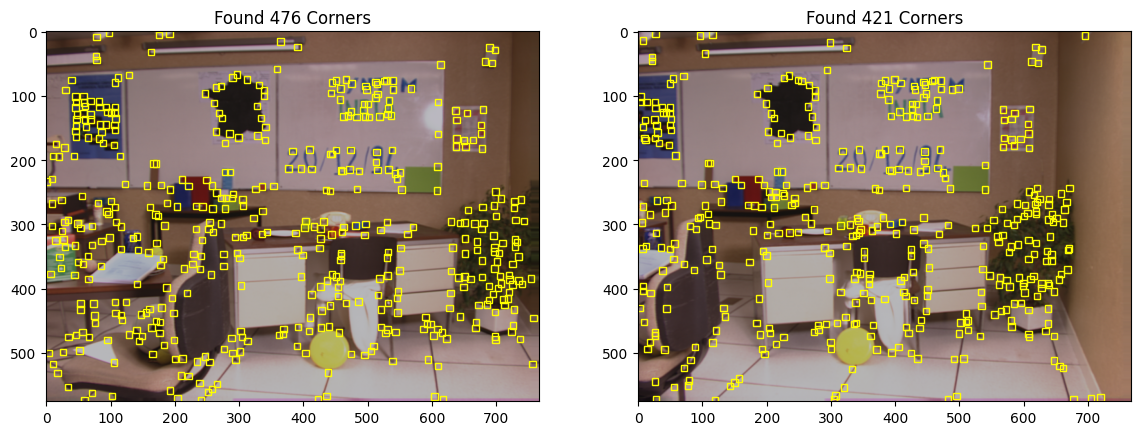

w = 10
t = 0.05
w_nms = 9
C1 = 476
C2 = 421


In [106]:
import time

# input images
I1 = np.array(Image.open('Sport0_OG0.bmp'), dtype='float')/255.
I2 = np.array(Image.open('Sport1_OG0.bmp'), dtype='float')/255.

# parameters to tune
w = 10
t = 0.05
w_nms = 9

tic = time.time()

# run feature detection algorithm on input images
C1, pts1, J1_0, J1_1, J1_2 = run_feature_detection(I1, w, t, w_nms)
C2, pts2, J2_0, J2_1, J2_2 = run_feature_detection(I2, w, t, w_nms)
toc = time.time() - tic

print('took %f secs'%toc)

# display results
plt.figure(figsize=(14,24))

# show corners on original images
ax = plt.subplot(1,2,1)
plt.imshow(I1)
for i in range(C1): # draw rectangles of size w around corners
    x,y = pts1[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False, color='yellow'))
# plt.plot(pts1[0,:], pts1[1,:], '.b') # display subpixel corners
plt.title('Found %d Corners'%C1)

ax = plt.subplot(1,2,2)
plt.imshow(I2)
for i in range(C2):
    x,y = pts2[:,i]
    ax.add_patch(patches.Rectangle((x-w/2,y-w/2),w,w, fill=False, color='yellow'))
# plt.plot(pts2[0,:], pts2[1,:], '.b')
plt.title('Found %d Corners'%C2)

plt.show()

# final values for parameters
print(f'w = {w}')
print(f't = {t}')
print(f'w_nms = {w_nms}')
print(f'C1 = {C1}')
print(f'C2 = {C2}')

#### Final values for parameters
* w = 10
* t = 0.05
* w_nms = 9
* C1 = 476
* C2 = 421

## Problem 3 (Programming): Feature matching (15 points)
Determine the set of one-to-one putative feature correspondences by performing
a brute-force search for the greatest correlation coefficient value (in the range
[-1, 1]) between the detected features in image 1 and the detected features in
image 2. Only allow matches that are above a specified correlation coefficient
threshold value (note that calculating the correlation coefficient allows for adjusting
the size of the matching window without changing the threshold value).
Further, only allow matches that are above a specified distance ratio threshold
value, where distance is measured to the next best match for a given feature.
Vary these parameters such that <strong> 220-275 </strong> putative feature correspondences are
established. Optional: constrain the search to coordinates in image 2 that are
within a proximity of the detected feature coordinates in image 1. The proximity is calculated using the subpixel coordinates of the detected feature coordinates in image 1 and image 2.  Given $(x_1, y_1)$ in image 1 and $(x_2, y_2)$ in image 2, you can think of a square with side length $p$, centered at $(x_2, y_2)$. Then, $(x_1, y_1)$ is within the proximity window if it lies inside that square.

Use the following formula to calculate the correlation coefficient (normalized cross correlation) between two image windows $I_1$ and $I_2$:
$$\frac{\sum_{x, y}\left[ I_1(x, y) - \overline{I_1} \right] \left[ I_2(x, y) - \overline{I_2} \right] }{\sqrt{\sum_{x, y}\left[ I_1(x, y) - \overline{I_1} \right]^2 \cdot \sum_{x, y}\left[ I_2(x, y) - \overline{I_2} \right]^2}}$$

where $I(x, y)$ is the pixel value of $I$ at $(x, y)$ and $\overline{I}$ is the mean value of $I$.

**Note: You must center each window at the sub-pixel corner coordinates while computing normalized cross correlation, i.e., you must use bilinear interpolation to compute the pixel values at non-integer coordinates; otherwise, you will lose points.**

#### Report your final values for:
* the size of the matching window
* the correlation coefficient threshold
* the distance ratio threshold
* the size of the proximity window (if used)
* the resulting number of putative feature correspondences (i.e., matched features)

#### Display figures for:
* pair of images, where the matched features in each of the images are indicated by a square window about the feature.

(You must use original (color) images to the draw boxes and correspondence lines)

A typical implementation takes around 40 seconds to run. If yours takes more than 80 seconds, you may lose points.


In [107]:
from scipy.interpolate import RegularGridInterpolator

def bilinear_interpolation1(pts,I_gray,w):
    # inputs:
    # pts: center points
    # I_gray: grayscale converted input image
    # w: window size
    #
    # output:
    # Interpolated pixel values for the corner windows

    half_win = w//2
    I_gray = np.pad(I_gray,pad_width=half_win)
    x = np.linspace(0,I_gray.shape[1]-1,I_gray.shape[1])
    y = np.linspace(0,I_gray.shape[0]-1,I_gray.shape[0])
    interp = RegularGridInterpolator((y, x),I_gray, bounds_error=False, fill_value=None)

    windows = []

    for c in range(pts.shape[1]):
    #   print(pts[0][c]-half_win,pts[0][c]+half_win+1,2*half_win-1)
      xx = np.linspace(pts[0][c]-half_win,pts[0][c]+half_win+1,2*half_win-1)
      yy = np.linspace(pts[1][c]-half_win,pts[1][c]+half_win+1,2*half_win-1)
      X, Y = np.meshgrid(xx, yy, indexing='ij')
      w1 = interp((Y,X)) # interpolate on a floating-point window
      windows.append(w1)

    return windows

def get_corr_coeff(wind1_curr, wind2_curr):
    # get correlation coefficient between windows 1 and 2 based on greyscale computations
    I1mean, I2mean = np.mean(wind1_curr), np.mean(wind2_curr)
    shifted_wind1, shifted_wind2 = wind1_curr-I1mean, wind2_curr-I2mean
    corr = np.sum(shifted_wind1 * shifted_wind2) / np.sqrt(np.sum(shifted_wind1**2) * np.sum(shifted_wind2**2))
    assert(-1.0 <= corr <= 1.0)
    return corr

def compute_ncc(I1, I2, pts1, pts2, w, p):
    # compute the normalized cross correlation between image patches I1, I2
    # result should be in the range [-1,1]
    #
    # Do ensure that windows are centered at the sub-pixel co-ordinates
    #      while computing normalized cross correlation.
    #
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # p is the size of the proximity window
    #
    # output:
    # normalized cross correlation matrix of scores between all windows in
    #    image 1 and all windows in image 2
    #
    
    # get cross correlation matrix
    l1, l2 = pts1.shape[1], pts2.shape[1]
    I1_gray, I2_gray = color_to_gray(I1), color_to_gray(I2)
    wind1, wind2 = bilinear_interpolation1(pts1, I1_gray, w), bilinear_interpolation1(pts2, I2_gray, w)
    scores = np.zeros((l1, l2))
    for i in range(l1):
        for j in range(l2):
            pt1, pt2 = pts1[:, i], pts2[:, j]
            if (np.linalg.norm(pt1 - pt2) < p):
                wind1_curr, wind2_curr = wind1[i], wind2[j]
                corr = get_corr_coeff(wind1_curr, wind2_curr)
                scores[i, j] = corr
            else:
                scores[i, j] = -1.0
    return scores


def perform_match(scores, t, d):
    # perform the one-to-one correspondence matching on the correlation coefficient matrix
    #
    # inputs:
    # scores is the NCC matrix
    # t is the correlation coefficient threshold
    # d distance ration threshold
    #
    # output:
    # 2xM array of the feature coordinates in image 1 and image 2,
    # where M is the number of matches.
    ind_I1 = []
    ind_I2 = []
    mask = np.ones(scores.shape)
    masked_scores = scores * mask
    while (np.max(masked_scores) > t):
        # get best and the next best correlation coefficients' values
        max_index = np.unravel_index(np.argmax(masked_scores, axis=None), masked_scores.shape)
        max_val = scores[max_index]
        scores[max_index] = -1
        # print(np.max(scores[max_index[0], :]), np.max(scores[:, max_index[1]]))
        next_best_val = np.max([np.max(scores[max_index[0], :]), np.max(scores[:, max_index[1]])])
        scores[max_index] = max_val

        # if best value is much better than the second best: keep the best val
        if ((1 - max_val) < ((1 - next_best_val) * d)): 
            ind_I1.append(max_index[0])
            ind_I2.append(max_index[1])
        
        # remove matched windows from considerations 
        mask[max_index[0], :] = 0
        mask[:, max_index[1]] = 0
        masked_scores = scores * mask
    print("The number of matches found: {}".format(len(ind_I1)))
    return np.array([ind_I1, ind_I2])


def run_feature_matching(I1, I2, pts1, pts2, w, t, d, p):
    # inputs:
    # I1, I2 are the input images
    # pts1, pts2 are the point to be matched
    # w is the size of the matching window to compute correlation coefficients
    # t is the correlation coefficient threshold
    # d distance ration threshold
    # p is the size of the proximity window
    #
    # outputs:
    # inds is a 2xk matrix of matches where inds[0,i] indexs a point pts1
    #     and inds[1,i] indexs a point in pts2, where k is the number of matches

    scores = compute_ncc(I1, I2, pts1, pts2, w, p)
    inds = perform_match(scores, t, d)
    return inds

The number of matches found: 244
took 1.953934 secs


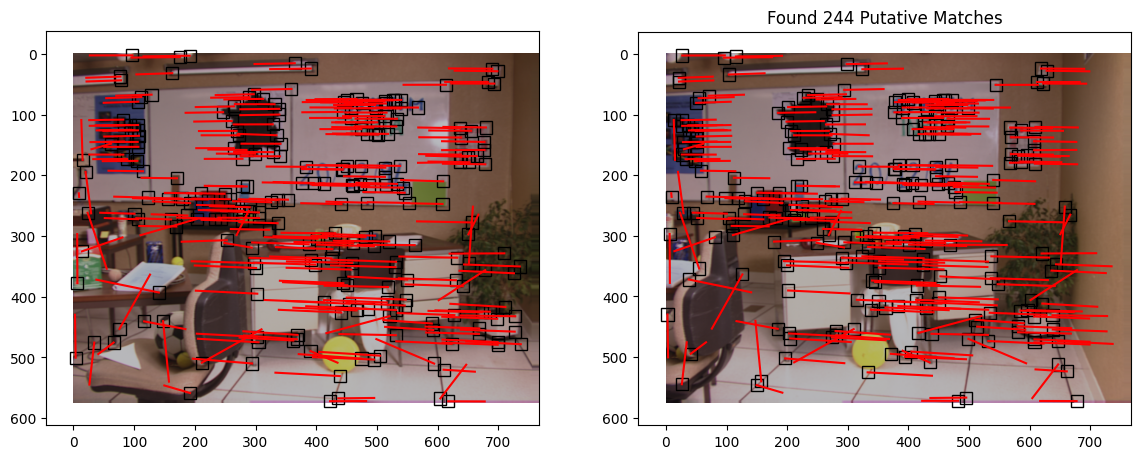

unique points in image 1: 244
unique points in image 2: 244
w = 20
t = 0.5
d = 0.9
p = 120


In [108]:
# parameters to tune
w = 20
t = 0.5
d = 0.9
p = 120

tic = time.time()
# run the feature matching algorithm on the input images and detected features
inds = run_feature_matching(I1, I2, pts1, pts2, w, t, d, p)
toc = time.time() - tic

print('took %f secs'%toc)

# create new matrices of points which contain only the matched features
match1 = pts1[:,inds[0,:].astype('int')]
match2 = pts2[:,inds[1,:].astype('int')]
# # display the results
plt.figure(figsize=(14,24))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
plt.title('Found %d Putative Matches'%match1.shape[1])
for i in range(match1.shape[1]):
    x1,y1 = match1[:,i]
    x2,y2 = match2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

print('unique points in image 1: %d'%np.unique(inds[0,:]).shape[0])
print('unique points in image 2: %d'%np.unique(inds[1,:]).shape[0])

# final values for parameters
print(f'w = {w}')
print(f't = {t}')
print(f'd = {d}')
print(f'p = {p}')

#### Final values for parameters
* The number of matches = 244
* w = 20
* t = 0.5
* d = 0.9
* p = 120

## Problem 4 (Programming): Outlier Rejection (20 points)
  
  The resulting set of putative point correspondences should contain both inlier
and outlier correspondences (i.e., false matches). Determine the set of inlier
point correspondences using the M-estimator Sample Consensus (MSAC) algorithm,
where the maximum number of attempts to find a consensus set is determined
adaptively. For each trial, you must use the 7-point algorithm (as described in
lecture) to estimate the essential matrix, resulting in 1 or 3 solutions. Note
that the 7-point algorithm requires the 2D points in normalized coordinates,
not in pixel coordinates. Calculate the (squared) Sampson error as a first
order approximation to the geometric error (hint: the error tolerance is
simpler to calculate in pixel coordinates using the fundamental matrix
$\mathtt{F} = \mathtt{K}^{\prime -\top} \mathtt{E} \mathtt{K}^{-1}$ than in
normalized coordinates using $\mathtt{E}$. You can avoid doing covariance
propagation).

Hint: this problem has codimension 1

Also: fix a random seed in your MSAC. If the instructional team cannot
reproduce your results, then you will lose points. But do not try to find a
good seed as the instructional team will run your code using different seeds.
Try to get 170-240 inliers every time you run MSAC.

#### Report your values for:
 * the probability $p$ that as least one of the random samples does not contain any outliers
 * the probability $\alpha$ that a given point is an inlier
 * the resulting number of inliers
 * the number of attempts to find the consensus set
 * the tolerance for inliers
 * the cost threshold
 * random seed

#### Display figures for:
* pair of images, where the inlier features in each of the images are indicated
by a square window about the feature and a line segment is drawn from the
feature to the coordinates of the corresponding feature in the other image

In [109]:
## Camera Calibration Matrices for the two cameras

K1 = np.array([[933.506409, 0, 377.685547],
               [0, 907.118286, 287.696991],
               [0, 0, 1]])

K2 = np.array([[934.712585, 0, 375.183105],
               [0, 903.909607, 290.008118],
               [0, 0, 1]])

In [110]:
import sympy as sp
from scipy.stats import chi2

def homogenize(x):
    # converts points from inhomogeneous to homogeneous coordinates
    return np.vstack((x, np.ones((1, x.shape[1]))))


def dehomogenize(x):
    # converts points from homogeneous to inhomogeneous coordinates
    return x[:-1] / x[-1]


Minimal cost at 1 (max trial 53695.66266424031) iterations: [2179.85018696]
Minimal cost at 2 (max trial 10730.942278876626) iterations: [2068.58089639]
Minimal cost at 3 (max trial 10730.942278876626) iterations: [2068.58089639]
Minimal cost at 4 (max trial 10730.942278876626) iterations: [2068.58089639]
Minimal cost at 5 (max trial 100.68611835460288) iterations: [1490.20519259]
Minimal cost at 6 (max trial 100.68611835460288) iterations: [1490.20519259]
Minimal cost at 7 (max trial 100.68611835460288) iterations: [1490.20519259]
Minimal cost at 8 (max trial 100.68611835460288) iterations: [1490.20519259]
Minimal cost at 9 (max trial 100.68611835460288) iterations: [1490.20519259]
Minimal cost at 10 (max trial 100.68611835460288) iterations: [1490.20519259]
Minimal cost at 11 (max trial 100.68611835460288) iterations: [1490.20519259]
Minimal cost at 12 (max trial 100.68611835460288) iterations: [1490.20519259]
Minimal cost at 13 (max trial 100.68611835460288) iterations: [1490.205192

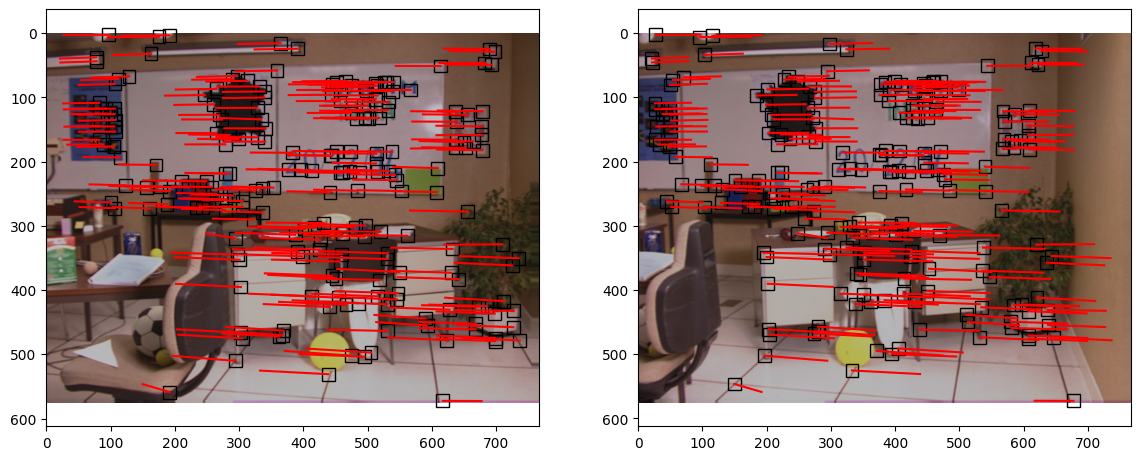

random seed = 4
p = 0.9
alpha = 0.999
tolerance = 10.827566170662733
threshold = 200
num_inliers = 215
num_attempts = 55
consensus min cost = [940.85328969]


In [111]:
from scipy.stats import chi2
import random
from sympy import symbols, Matrix, solveset
from sympy.solvers import solve


# np.random.seed(38)
def choose_random_column_indices(array_2d, num_columns_to_choose):
    """
    Chooses a random sample of columns from a 2D NumPy array.
    
    Parameters:
        array_2d (ndarray): The input 2D NumPy array.
        num_columns_to_choose (int): The number of columns to choose randomly.
        
    Returns:
        random_column_indices: Indices of the randomly chosen columns.
    """
    # Number of columns in the array
    num_columns = array_2d.shape[1]
    # Randomly choose column indices
    random_column_indices = np.random.choice(num_columns, size=num_columns_to_choose, replace=False)
    return random_column_indices

def sampson_error_for_F(F, pts1_samp, pts2_samp):
    # compute sampson error given samples and H
    pts1_samp_inhomo = pts1_samp
    pts2_samp_inhomo = pts2_samp
    n = pts1_samp.shape[1]
    eps = np.zeros((n,1))
    J = np.zeros((n,4))
    sampSqr = np.zeros((n,1))
    for j in range(n):
        pt1, pt2 = pts1_samp_inhomo[:, j], pts2_samp_inhomo[:, j]
        xj, yj, xjprime, yjprime = pt1[0], pt1[1], pt2[0], pt2[1]
        f11, f12, f13, f21, f22, f23, f31, f32, f33 = F[0,0], F[0,1], F[0,2], F[1,0], F[1,1], F[1,2], F[2,0], F[2,1], F[2,2]
        eps[j, :] = xj*xjprime*f11 + xj*yjprime*f21 + xj*f31 + yj*xjprime*f12 + yj*yjprime*f22 + yj*f32 + xjprime*f13 + yjprime*f23 + f33
        J[j, :] = np.array([xjprime*f11+yjprime*f21+f31, xjprime*f12+yjprime*f22+f32, xj*f11+yj*f12+f13, xj*f21+yj*f22+f23])
        epsi, Ji = eps[j, :], J[j, :]
        # print(epsi, Ji)
        sampSqr[j, :] = (epsi.T @ epsi) / (Ji@Ji.T)
    return sampSqr

def sampson_error_for_E(E, pts1_samp, pts2_samp):
    # compute sampson error given samples and H
    pts1_samp_inhomo = pts1_samp
    pts2_samp_inhomo = pts2_samp
    n = pts1_samp.shape[1]
    eps = np.zeros((n,1))
    J = np.zeros((n,4))
    sampSqr = np.zeros((n,1))
    for j in range(n):
        pt1, pt2 = pts1_samp_inhomo[:, j], pts2_samp_inhomo[:, j]
        xj, yj, xjprime, yjprime = pt1[0], pt1[1], pt2[0], pt2[1]
        e11, e12, e13, e21, e22, e23, e31, e32, e33 = E[0,0], E[0,1], E[0,2], E[1,0], E[1,1], E[1,2], E[2,0], E[2,1], E[2,2]
        eps[j, :] = xj*xjprime*e11 + xj*yjprime*e21 + xj*e31 + yj*xjprime*e12 + yj*yjprime*e22 + yj*e32 + xjprime*e13 + yjprime*e23 + e33
        J[j, :] = np.array([xjprime*e11+yjprime*e21+e31, xjprime*e12+yjprime*e22+e32, xj*e11+yj*e12+e13, xj*e21+yj*e22+e23])
        epsi, Ji = eps[j, :], J[j, :]
        sampSqr[j, :] = (epsi.T @ epsi) / (Ji@Ji.T)
    return sampSqr

def compute_MSAC_cost(n, tol, error):
    # Input:
    # n: the number of points to compute the cost
    # tol: Reprojection error tolerance
    # error - pre-computed sampson error

    # Output:
    # cost, inliers indices

    inlier_ind = []
    cost = 0
    for j in range(n):
        if (error[j] <= tol):
            cost += error[j]
            inlier_ind.append(j)
        else:
            cost += tol
    return cost, inlier_ind

def display_results(E, title):
    print(title+' =')
    print(E/np.linalg.norm(E)*np.sign(E[-1,-1]))

def solveESevenPt(pts1, pts2):
    n = pts1.shape[1] # n = 7
    pts1_homo, pts2_homo = homogenize(pts1), homogenize(pts2)
    
    # load equations for A
    A = np.zeros((n, 9))
    for i in range(n):
        a = np.kron(pts2_homo[:, i].T, pts1_homo[:, i].T)
        A[i, :] = a.reshape(-1)
    _, _, V = np.linalg.svd(A)

    # solve right null space for A
    e_sols = V[-2:,:].T 
    E1 = e_sols[:,0].reshape(3,3)
    E2 = e_sols[:,1].reshape(3,3)

    # solve alpha by setting det(E)=0
    alpha = symbols('alpha')
    E = Matrix(alpha*E1 + E2)
    alpha_sol = solve(Matrix.det(E), alpha) 

    # pick near-real alpha solutions
    alpha_sol = np.array(alpha_sol)
    alpha_sol = alpha_sol.astype(np.complex64)
    alpha_sol = [a.real for a in alpha_sol if np.isclose(a.imag, 0, atol=1e-20)]
    
    # load E solutions and return
    E_sols = []
    for alp in alpha_sol:
        E_i = alp*E1 + E2
        # enforce the rank-2 constraint
        U, _, V = np.linalg.svd(E_i)
        sig_rank2 = np.diag([1, 1, 0])
        E_i_rank2 = U @ sig_rank2 @ V
        E_sols.append(E_i_rank2)
    return E_sols

def E_to_F(E, K1, K2):
    # convert essential matrix solutions to fundamental matrix solutions
    K2_inv = np.linalg.inv(K2)  
    K1_inv = np.linalg.inv(K1)
    F = K2_inv.T @ E @ K1_inv
    return F

def determine_inliers(pts1, pts2, thresh, tol, p, K1, K2):
    # Inputs:
    #    pts1 - matched feature correspondences in image 1
    #    pts2 - matched feature correspondences in image 2
    #    thresh - cost threshold
    #    tol - reprojection error tolerance
    #    p - probability that as least one of the random samples does not contain any outliers
    #    K1 - the camera calibration matrix associated with image 1
    #    K2 - the camera calibration matrix associated with image 2
    #
    # Output:
    #    consensus_min_cost - final cost from MSAC
    #    consensus_min_cost_model - essential matrix E
    #    inliers - list of indices of the inliers corresponding to input data
    #    trials - number of attempts taken to find consensus set

    np.random.seed(seed)
    trials = 0
    max_trials = np.inf
    consensus_min_cost = np.inf
    consensus_min_cost_model = np.zeros((3,3))
    n = pts1.shape[1]
    s = 7 # sample size = 7
    trials = 0
    inliers = [0]*39

    # get image coordinates of the point sets for cost eval
    K1Inv = np.linalg.inv(K1)
    K2Inv = np.linalg.inv(K2)
    pts1_norm_coor = dehomogenize(K1Inv @ homogenize(pts1))
    pts2_norm_coor = dehomogenize(K2Inv @ homogenize(pts2))

    while ((trials < max_trials) and (consensus_min_cost > thresh)): # "for" loop's number of rounds executing cannot be updated. So use "while" instead
        samp_inds = choose_random_column_indices(pts1, s)
        pts1_samp = pts1_norm_coor[:, samp_inds]
        pts2_samp = pts2_norm_coor[:, samp_inds]

        # solve E
        E_sols = solveESevenPt(pts1_samp, pts2_samp)
        # print(E_sols)

        for j in range(len(E_sols)):
            E = E_sols[j]

            # convert to F to compute the cost
            F = E_to_F(E, K1, K2)

            # evaluate sampson's error for F
            # print(F,  pts1_norm_coor, pts2_norm_coor)
            # error_E = sampson_error_for_E(E, pts1, pts2)
            error = sampson_error_for_F(F, pts1, pts2)
            # print(error)

            # evaluate and update MSAC sampson's cost
            cost, inlier_ind = compute_MSAC_cost(n, tol, error)
            if (cost < consensus_min_cost):
                consensus_min_cost = cost
                consensus_min_cost_model = E
                inliers = inlier_ind
                w = len(inlier_ind) / n
                max_trials = np.log(1-p) / np.log(1-(w**s))
        trials += 1
        print("Minimal cost at {} (max trial {}) iterations: {}".format(trials, max_trials, consensus_min_cost))

    print("Final minimal cost after {} (max trial {}) iterations: {}".format(trials, max_trials, consensus_min_cost))
    return consensus_min_cost, consensus_min_cost_model, inliers, trials


# MSAC parameters
seed = 4
thresh = 200
codim = 1
p = 0.9
alpha = 0.999
tol = chi2.ppf(alpha, codim)


tic=time.time()

cost_MSAC, E_MSAC, inliers, trials = determine_inliers(match1, match2, thresh, tol, p, K1, K2)

# choose just the inliers
xin1 = match1[:,inliers]
xin2 = match2[:,inliers]

toc=time.time()
time_total=toc-tic

# display the results
print('took %f secs'%time_total)
print('%d iterations'%trials)
print('inlier count: ',len(inliers))
print('inliers: ',inliers)
print('MSAC Cost = %.9f'%cost_MSAC)
display_results(E_MSAC, 'E_MSAC')

# display the figures
plt.figure(figsize=(14,8))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)

for i in range(xin1.shape[1]):
    x1,y1 = xin1[:,i]
    x2,y2 = xin2[:,i]
    ax1.plot([x1, x2],[y1, y2],'-r')
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=False))
    ax2.plot([x2, x1],[y2, y1],'-r')
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=False))

plt.show()

# final values for parameters
print(f'random seed = {seed}')
print(f'p = {p}')
print(f'alpha = {alpha}')
print(f'tolerance = {tol}')
print(f'threshold = {thresh}')
print(f'num_inliers = {len(inliers)}')
print(f'num_attempts = {trials}')
print(f'consensus min cost = {cost_MSAC}')

## Problem 5 (Programming): Linear Estimation of the Essential Matrix (15 points)
  Estimate the essential matrix $\mathtt{E}_\text{DLT}$ from the
  resulting set of inlier correspondences using the direct linear
  transformation (DLT) algorithm.  Include
  the numerical values of the resulting $\mathtt{E}_\text{DLT}$, scaled
  such that $\lVert\mathtt{E}_\text{DLT}\rVert_\text{Fro} = 1$

In [112]:
def estimate_essential_matrix_linear(x1, x2, K1, K2):
    # Inputs:
    #    x1 - inhomogeneous inlier correspondences in image 1
    #    x2 - inhomogeneous inlier correspondences in image 2
    #
    # Outputs:
    #    E - the DLT estimate of the essential matrix
    K1Inv, K2Inv = np.linalg.inv(K1), np.linalg.inv(K2)
    x1_norm_coor = dehomogenize(K1Inv @ homogenize(x1)) 
    x1_norm_coor_homo = homogenize(x1_norm_coor) 
    x2_norm_coor = dehomogenize(K2Inv @ homogenize(x2)) 
    x2_norm_coor_homo = homogenize(x2_norm_coor) 

    # estimate essential matrix
    n = x1.shape[1]
    A = np.zeros((n, 9))
    for j in range(n):
        x1j, x2j = x1_norm_coor_homo[:, j], x2_norm_coor_homo[:, j]
        a = np.kron(x2j.T, x1j.T)
        A[j, :] = a
    _ , _, Vt = np.linalg.svd(A)
    e = Vt[-1, :]
    E = np.reshape(e, (3,3))

    # enforce rank-2 constraint
    U, sig, Vt = np.linalg.svd(E)
    sig_rank2 = np.diag([sig[0], sig[1], 0])
    E_rank2 = U @ sig_rank2 @ Vt

    # normalize so that Enorm=1
    E_rank2 = E_rank2 / np.linalg.norm(E_rank2)
    return E_rank2

# compute the linear estimate
time_start=time.time()
E_DLT = estimate_essential_matrix_linear(xin1, xin2, K1, K2)
time_total=time.time()-time_start

# display the resulting E_DLT, scaled with its frobenius norm
display_results(E_DLT, 'E_DLT')

# cost = eval(E_DLT, xin1, xin2, K1, K2)
# print(f"Cost: {cost}")




E_DLT =
[[ 1.89729771e-06 -5.36091051e-02 -4.49263172e-03]
 [ 3.44509119e-02  1.06754350e-02  7.07991681e-01]
 [ 3.04726360e-03 -7.03231069e-01  3.09963860e-03]]


## Problem 6 (Programming): Nonlinear Estimation of the Essential Matrix (70 points)
  Retrieve the normalized camera projection matrices $\hat{\mathtt{P}} =
  [\mathtt{I} \,|\, \boldsymbol{\mathrm{0}}]$ and $\hat{\mathtt{P}}' =
  [\mathtt{R} \,|\, \boldsymbol{\mathrm{t}}]$ from
  $\mathtt{E}_\text{DLT}$.  Use the resulting camera rotation and translation
  associated with the second camera and the triangulated 3D points as an
  initial estimate to an iterative estimation method, specifically the sparse
  Levenberg-Marquardt algorithm, to determine the Maximum Likelihood estimate
  of the essential matrix that minimizes the reprojection error.  The initial
  estimate of the 3D points must be determined using the two-view optimal
  triangulation method described in lecture (algorithm 12.1 in the Hartley \&
  Zisserman book, but use the ray-plane intersection method for the final step
  instead of the homogeneous method). Additionally, you must parameterize the
  second camera rotation using the angle-axis representation
  $\boldsymbol{\omega}$ (where $[\boldsymbol{\omega}]_\times = \ln \mathtt{R}$)
  of a 3D rotation, the second camera unit translation vector
  $\boldsymbol{\mathrm{t}}$ using the parameterization of the $n$-sphere, and
  the homogeneous 3D scene points that are being adjusted using the
  parameterization of homogeneous vectors.
  
  Report the initial cost (i.e., cost at iteration 0) and the cost at the end
  of each successive iteration. Show the numerical values for the final
  estimate of the second camera rotation $\boldsymbol{\omega}_\text{LM}$ and
  $\mathtt{R}_\text{LM}$, second camera unit translation vector
  $\boldsymbol{\mathrm{t}}_\text{LM}$, and the essential  matrix
  $\mathtt{E}_\text{LM} = [\boldsymbol{\mathrm{t}}_\text{LM}]_\times
  \mathtt{R}_\text{LM}$.

In [113]:
def get_right_null_space(A):
    # get right null space of A
    _, _, Vt = np.linalg.svd(A)
    return Vt[-1, :]

def get_left_null_space(A):
    # get right null space of A
    U, _, _ = np.linalg.svd(A)
    Ut = U.T
    return Ut[-1, :]

def get_ls_t(t, f):
    # get the line given t at image 1
    return np.array([t*f, 1, -t])

def get_lsprime_t(t, fprime, a, b, c, d):
    # get the line given t at image 2
    return np.array([-fprime*(c*t+d), a*t+b, c*t+d])

def s(t, a, b, c, d, f, fprime):
    # function for s(t)
    st = (t**2)/(1 + (f**2) * (t**2)) + (c*t+d)**2 / ((a*t+b)**2 + fprime**2 * (c*t+d)**2)
    return st

def get_line_point_min_dist_to_pt(line, pt):
    # get a point on the line that has the minimal distance to pt
    pt_homo = homogenize(pt)
    tr = np.eye(4)
    tr[:3, -1] = line
    line_homo = homogenize(line)
    ptprime_homo = tr @ pt_homo
    lamb = - ((line_homo @ ptprime_homo) / (line_homo@pt_homo - line_homo@ptprime_homo))
    pt_pi_homo = lamb * pt_homo + (1-lamb) * ptprime_homo
    pt_pi = dehomogenize(pt_pi_homo)
    return pt_pi

def apply_optimal_correction(x1, x2, E):
    # Input:
    #    x1 - Homogeneous point in image 1 in normalized coordinates (3 x 1)
    #    x2 - Homogeneous point in image 2 in normalized coordinates (3 x 1)
    #    E - DLT estimate of the essential matrix (3 x 3)
    # Output:
    #    x1_corrected - Homogeneous corrected point in image 1 in normalized coordinates (3 x 1)
    #    x2_corrected - Homogeneous corrected point in image 2 in normalized coordinates (3 x 1)
    # print(x1, x2)
    # update Es in special form
    x, y, w, xprime, yprime, wprime = x1[0], x1[1], x1[2], x2[0], x2[1], x2[2]
    T = np.array([[w,0,-x],[0,w,-y],[0,0,w]])
    Tprime = np.array([[wprime,0,-xprime],[0,wprime,-yprime],[0,0,wprime]])
    TInv, TprimeInv = np.linalg.inv(T), np.linalg.inv(Tprime)
    Es = TprimeInv.T @ E @ TInv
    
    # compute epipoles from Es
    e, eprime = get_right_null_space(Es), get_right_null_space(Es.T)
    e /= (np.sqrt(e[0]**2 + e[1]**2))
    eprime /= (np.sqrt(eprime[0]**2 + eprime[1]**2))

    # update Es again using epipoles
    R = np.array([[e[0], e[1], 0],[-e[1], e[0], 0],[0, 0, 1]])
    Rprime = np.array([[eprime[0], eprime[1], 0],[-eprime[1], eprime[0], 0],[0, 0, 1]])
    Es = Rprime @ Es @ R.T
    
    # solve ts, and find the minimal t
    f, fprime = e[2], eprime[2]
    a, b, c, d = Es[1,1], Es[1,2], Es[2,1], Es[2,2]
    t6 = - d*a**(2)*c*f**(4) + b*a*c**(2)*f**(4)
    t5 = a**(4) + 2*fprime**(2)*a**(2)*c**(2) - a**(2)*d**(2)*f**(4) + b**(2)*c**(2)*f**(4) + fprime**(4)*c**(4)
    t4 = 4*a**(3)*b - 2*a**(2)*c*d*f**(2) + 4*fprime**(2)*a**(2)*c*d + 2*a*b*c**(2)*f**(2) + 4*fprime**(2)*a*b*c**(2) - a*b*d**(2)*f**(4) + b**(2)*c*d*f**(4) + 4*fprime**(4)*c**(3)*d
    t3 = 6*a**(2)*b**(2) - 2*a**(2)*d**(2)*f**(2) + 2*fprime**(2)*a**(2)*d**(2) + 8*fprime**(2)*a*b*c*d + 2*b**(2)*c**(2)*f**(2) + 2*fprime**(2)*b**(2)*c**(2) + 6*fprime**(4)*c**(2)*d**(2)
    t2 = - a**(2)*c*d + 4*a*b**(3) + a*b*c**(2) - 2*a*b*d**(2)*f**(2) + 4*fprime**(2)*a*b*d**(2) + 2*b**(2)*c*d*f**(2) + 4*fprime**(2)*b**(2)*c*d + 4*fprime**(4)*c*d**(3)
    t1 = - a**(2)*d**(2) + b**(4) + b**(2)*c**(2) + 2*fprime**(2)*b**(2)*d**(2) + fprime**(4)*d**(4)
    t0 = c*b**(2)*d - a*b*d**(2)
    coeff = [t6, t5, t4, t3, t2, t1, t0]
    tSols = np.roots(coeff)
    tSols = tSols.real
    st = [] # evaluate s(t) and find minimum
    for t in tSols:
        st_val = s(t, a, b, c, d, f, fprime)
        st.append(st_val)
    s_t_infty = 1/(f**2) + (c**2)/(a**2 + fprime**2 * c**2) # add value evaled at t=infty
    st.append(s_t_infty)
    tmin_ind = np.argmin(st) # get tmin index having minimum s(t) value
    
    # find transformed epipolar lines
    if (tmin_ind >= len(tSols)): # infty reaches minimum
        ls_tmin = np.array([f, 0, -1])
        lsprime_tmin = np.array([-fprime*c, a, c])
    else: # some tmin in tSols list reaches minimum
        tmin = tSols[tmin_ind]
        ls_tmin = get_ls_t(tmin, f)
        lsprime_tmin = get_lsprime_t(tmin, fprime, a, b, c, d)

    # get closest points on the lines
    xs = np.array([-ls_tmin[0] * ls_tmin[2], -ls_tmin[1] * ls_tmin[2], (ls_tmin[0] **2) + (ls_tmin[1]**2)])[:, None]
    xsprime = np.array([-lsprime_tmin[0] * lsprime_tmin[2], -lsprime_tmin[1] * lsprime_tmin[2], (lsprime_tmin[0] **2) + (lsprime_tmin[1]**2)])[:, None]

    # inverse transform the points back to original coordinates
    x1_corrected = TInv @ R.T @ xs
    x2_corrected = TprimeInv @ Rprime.T @ xsprime
    return x1_corrected, x2_corrected


def triangulate_scene_point(x1, x2, E, Pp):
    # Input:
    #    x1 - Homogeneous point in image 1 in normalized coordinates (3 x 1)
    #    x2 - Homogeneous point in image 2 in normalized coordinates (3 x 1)
    #    E - DLT estimate of the essential matrix (3 x 3)
    #    Pp - the second normalized camera projection matrix
    # Output:
    #    X_scene = Triangulated homogeneous 3D scene point (4 x 1)

    # optimally correct the points first before triangulations
    x1_corr, x2_corr = apply_optimal_correction(x1, x2, E)
    x1_corr, x2_corr = x1_corr[:, 0], x2_corr[:, 0]

    # triangulations based on the optimally corrected points
    P1 = np.array([[1,0,0,0], [0,1,0,0], [0,0,1,0]]) # set P1 to [I | 0]
    x, y, w, xprime, yprime, wprime = x1_corr[0], x1_corr[1], x1_corr[2], x2_corr[0], x2_corr[1], x2_corr[2] 
    lprime = E @ x1_corr
    aprime, bprime, cprime = lprime[0], lprime[1], lprime[2]
    lprimePerp = np.array([-bprime*wprime, aprime*wprime, bprime*xprime-aprime*yprime])
    pi = Pp.T @ lprimePerp
    a, b, c, d = pi[0], pi[1], pi[2], pi[3]
    C = np.array([0,0,0,1]) # for canonical camera
    X = np.array([x,y,w,0])
    # P1plus = P1.T @ np.linalg.inv(P1@P1.T)
    # X = P1plus @ x1

    # get 3D line and plane intersaction
    Xpi = np.array([d*x, d*y, d*w, -(a*x+b*y+c*w)])
    Xpi = Xpi[:, None]
    return Xpi


def decompose_essential_matrix(E, pt1, pt2):
    #
    # This function decomposes the essential matrix into a rotation
    # matrix and translation vector such that we have normalized cameras P1 = [I | 0]
    # and P2 = [R | t].  t is a unit vector indicating the direction of translation.
    #
    # Input:
    #    E - DLT estimate of the essential matrix (3 x 3)
    #    pt1, pt2 - One point correspondence in normalized coordinates
    # Output:
    #    R - The rotation matrix
    #    t - The translation vector
    P1 = np.hstack([np.eye(3), np.zeros((3,1))])
    U, D, Vt = np.linalg.svd(E)

    # solve Rs
    Z = np.array([[0,-1,0],[1,0,0],[0,0,1]])
    R1, R2 = U @ Z @ Vt, U @ Z.T @ Vt
    if np.isclose(np.linalg.det(R1), -1, atol=1e-5):
        R1 = -R1
    if np.isclose(np.linalg.det(R2), -1, atol=1e-5):
        R2 = -R2
    # solve ts
    # print(U[:,-1])
    t1, t2 = U[:,-1], -U[:,-1] 
    
    # triangulate to determine the point-in-front camera
    P1prime, P2prime, P3prime, P4prime = np.hstack([R1, t1[:, None]]), np.hstack([R1, t2[:, None]]), np.hstack([R2, t1[:, None]]), np.hstack([R2, t2[:, None]])
    PprimeList = [P1prime, P2prime, P3prime, P4prime]
    for Pprime in PprimeList:
        xpi_Pprime = triangulate_scene_point(pt1[:, 0], pt2[:, 0], E, Pprime)
        xpi_P_cam, xpi_Pprime_cam = P1 @ xpi_Pprime, Pprime @ xpi_Pprime
        z, zprime = xpi_P_cam[2,0], xpi_Pprime_cam[2,0]
        if ((z>=0) and (zprime>=0)):
            PprimeSol = Pprime
            break

    # output the rotation and translation matrices
    R = PprimeSol[:3, :3]
    t = PprimeSol[:3, 3]
    return R,t

In [114]:
# Unit tests for optimal triangulation (Do not change)

def check_values_triangulation():
    eps = 1e-5  # Floating point error threshold

    # Givens
    # The essential matrix (3 x 3)
    E = np.load('unit_test/E.npy')

    # Homogeneous image points in normalized coordinates (3 x 1) each
    x1 = np.load('unit_test/x1.npy')
    x2 = np.load('unit_test/x2.npy')

    # Second normalized projection matrix P' (3 x 4)
    P_target = np.load('unit_test/P_target.npy')

    # Targets
    x1_corr_target = np.load('unit_test/x1_corr.npy')
    x2_corr_target = np.load('unit_test/x2_corr.npy')

    # Compute
    # R,t = decompose_essential_matrix(E, x1[0], x2[0])
    R,t = decompose_essential_matrix(E, x1[:,0].reshape(3,1), x2[:,0].reshape(3,1))
    P = np.hstack((R,t.reshape(3,1)))
    x1_corr, x2_corr = np.empty((3,0)), np.empty((3,0))
    X_scene = np.empty((4,0))
    for i in range(x1.shape[1]):
      x1c, x2c = apply_optimal_correction(x1[:,i], x2[:,i], E)
      x1_corr = np.concatenate((x1_corr,x1c),axis=1)
      x2_corr = np.concatenate((x2_corr,x2c),axis=1)
      # print("hh")
      # print(triangulate_scene_point(x1[:,i], x2[:,i], E, P))
      X_scene = np.concatenate((X_scene,triangulate_scene_point(x1[:,i], x2[:,i], E, P)), axis=1)

    # Verify optimal corrected points
    P_valid = np.all(np.abs(P - P_target) < eps)
    # print("P")
    # print(P)
    # print("P_tg")
    # print(P_target)
    x1_corr_valid = np.all(np.abs(dehomogenize(x1_corr_target) - dehomogenize(x1_corr)) < eps)
    x2_corr_valid = np.all(np.abs(dehomogenize(x2_corr_target) - dehomogenize(x2_corr)) < eps)

    # Verify triangulated 3D scene point
    x1_proj = dehomogenize(np.hstack((np.eye(3),np.zeros((3,1)))) @ X_scene)
    x2_proj = dehomogenize(P @ X_scene)

    x1_proj_valid = np.all(np.abs(x1_proj - dehomogenize(x1_corr)) < eps)
    x2_proj_valid = np.all(np.abs(x2_proj - dehomogenize(x2_corr)) < eps)
    # print("proj x2")
    # print(x2_proj, dehomogenize(x2_corr))
    # print(x1_proj_valid, x2_proj_valid)
    X_scene_valid = x1_proj_valid and x2_proj_valid

    print(f'Computed second normalized camera projection matrix is equal to the given value +/- {eps}: {P_valid}')
    print(f'Computed optimal corrected point in image 1 is equal to the given value +/- {eps}: {x1_corr_valid}')
    print(f'Computed optimal corrected point in image 2 is equal to the given value +/- {eps}: {x2_corr_valid}')
    print(f'Computed triangulated 3D scene point is equal to the given value +/- {eps}: {X_scene_valid}')

check_values_triangulation()

Computed second normalized camera projection matrix is equal to the given value +/- 1e-05: True
Computed optimal corrected point in image 1 is equal to the given value +/- 1e-05: True
Computed optimal corrected point in image 2 is equal to the given value +/- 1e-05: True
Computed triangulated 3D scene point is equal to the given value +/- 1e-05: True


In [115]:
# Note that np.sinc is different than defined in class
def get_right_null_space_with_check(A):
    # get right null space of A and check if it's a small rotation
    _, sig, Vt = np.linalg.svd(A)
    is_small_rot = False
    if np.isclose(sig[-2], 0, atol=1e-5):
        print(f"Is small rotation! {sig}")
        is_small_rot = True # Very small rotation if null space is more than 1 column
    return Vt[-1, :], is_small_rot

def sinc(x):
    # Returns a scalar valued sinc value
    if (x==0):
        return 1
    else:
        return np.sin(x) / x

def d_sinc(x):
    if (x==0):
        return 0
    else:
        return (np.cos(x) / x) - (np.sin(x) / (x**2))
    

def skew(w):
    # Returns the skew-symmetrix represenation of a vector
    w_skew = np.zeros((3, 3))
    w_skew[0, 1], w_skew[1, 0] = -w[2], w[2] 
    w_skew[0, 2], w_skew[2, 0] = w[1], -w[1] 
    w_skew[1, 2], w_skew[2, 1] = -w[0], w[0] 
    return w_skew


def parameterize_rotation_matrix(R):
    # Parameterizes rotation matrix into its axis-angle representation
    # solve null space of R-I for v
    v, is_small_rot = get_right_null_space_with_check(R - np.eye(3))  
    vhat = np.array([R[2, 1] - R[1, 2],
        R[0, 2] - R[2, 0],
        R[1, 0] - R[0, 1]])
    trace_R = np.trace(R)
    sinTheta = np.dot(v, vhat)/2
    cosTheta = (trace_R-1)/2
    
    # solve theta, w
    theta = np.arctan(sinTheta/cosTheta)
    if is_small_rot:
        w = vhat/2
    else:
        w = theta * v
        w_norm = np.linalg.norm(w)
        if (w_norm > np.pi):
            w = (1 - (2*np.pi/w_norm)*np.ceil((w_norm-np.pi)/(2*np.pi))) * w
    return w, theta


def deparameterize_rotation_matrix(w):
    # Deparameterizes to get rotation matrix
    theta = np.linalg.norm(w)
    ratio = (1-np.cos(theta))/(theta**2)
    if (ratio == np.nan): # small rotation
        R = np.eye(3) + skew(w)
    else: # normal rotation
        R = np.eye(3)*np.cos(theta) + sinc(theta)*skew(w) + ratio*np.outer(w, w)
    return R


def unitize(x):
    return x / np.linalg.norm(x)


def parameterize_homog(v_bar):
    # Given a homogeneous vector v_bar (n x 1) return its minimal parameterization ((n - 1) x 1)
    v_bar = v_bar / (np.linalg.norm(v_bar))
    a, b = v_bar[0], v_bar[1:]
    v = (2/sinc(np.arccos(a))) * b
    v_norm = np.linalg.norm(v)
    if (v_norm > np.pi):
        # print("normalizing!")
        v = (1 - ( (2*np.pi/v_norm) * (np.ceil((v_norm - np.pi) / (2*np.pi))) )) * v
    return v


def deparameterize_homog(v):
    # Given a parameterized homogeneous vector (n x 1) return its deparameterization ((n + 1) x 1)
    param_dim, deparam_dim = v.shape[0], v.shape[0]+1
    v_norm = np.linalg.norm(v)
    a = np.cos(v_norm/2)
    b = v * (sinc(v_norm/2)/2)
    v_bar = np.zeros((deparam_dim,1))
    v_bar[0] = a
    v_bar[1:] = b
    v_bar = v_bar / (np.linalg.norm(v_bar))
    return v_bar


def partial_vbar_partial_v(v):
    # Input:
    # v - homogeneous parameterized vector (n x 1)
    # Output:
    # partial_vbar_partial_v - derivative of vbar w.r.t v ((n + 1) x n)
    param_dim, deparam_dim = v.shape[0], v.shape[0]+1
    v_norm = np.linalg.norm(v)
    partial_vbar_partial_v = np.zeros((deparam_dim,param_dim))
    
    # get vector deparameterizations
    v_bar = deparameterize_homog(v)
    
    # set partial_a_partial_v
    if (v_norm != 0):
        partial_vbar_partial_v[0, :] = -0.5 * v_bar[1:, 0]

    # set partial_b_partial_v
    iden = np.eye(param_dim)
    if (v_norm != 0):
        partial_vbar_partial_v[1:, :] = (sinc(v_norm/2)/2) * iden + (1/(4*v_norm)) * (d_sinc(v_norm/2) * np.outer(v, v))        
    else:
        partial_vbar_partial_v[1:, :] = 0.5 * iden
    
    return partial_vbar_partial_v

def get_dtheta_dw(theta, w):
    # get dtheta_dw
    return w.T/theta

def get_ds_dtheta(theta):
    # get dtheta_dw
    return (theta*np.sin(theta) - 2*(1 - np.cos(theta)))/(theta**3)

def get_dtheta_dw(theta, w):
    return w.T/theta

def partial_x_hat_partial_w(R, w, t, X):
    # Compute the (partial x_hat) / (partial omega) component of the jacobian
    # Inputs:
    #    R - 3x3 rotation matrix
    #    w - 3x1 axis-angle parameterization of R
    #    t - 3x1 translation vector
    #    X - 4x1 3D inlier point
    #
    # Output:
    #    dx_hat_dw -  matrix of size 2x3
    v, T = X[:3], X[3,0]
    vprime = R @ v

    # get 2d projected image point
    xhat_homo = vprime + T*t
    xhat = dehomogenize(xhat_homo) 
    xtilhat, ytilhat = xhat[0,0], xhat[1,0]

    # get dx_dvprime
    what = vprime[2,0] + t[2,0]*T
    dx_dvprime = np.array([[1/what, 0, -xtilhat/what],[0, 1/what, -ytilhat/what]])

    # get dvprime_dw
    theta = np.linalg.norm(w)
    minus_vskew = skew(-v)
    if (np.isclose(theta, 0, atol=1e-5)):
        dvprime_dw = minus_vskew
    else:
        dtheta_dw = get_dtheta_dw(theta, w) # 1*3
        ds_dtheta = get_ds_dtheta(theta) # 1
        s = (1-np.cos(theta))/(theta**2)
        dvprime_dw = sinc(theta)*minus_vskew + \
                    np.cross(w[:, 0], v[:, 0])*d_sinc(theta)*dtheta_dw + \
                    np.cross(w[:, 0], np.cross(w[:, 0], v[:, 0]))*ds_dtheta*dtheta_dw + \
                    s*(skew(w)@skew(-v) + skew(-np.cross(w[:, 0], v[:, 0])))
    
    # combine and output
    dx_hat_dw = dx_dvprime @ dvprime_dw
    return dx_hat_dw

def householder_n_sphere(x):
    # Compute the householder matrix for vector x
    # Inputs:
    #    x - n x 1 vector
    # Output:
    #    H - n x n Householder matrix
    n = x.shape[0]
    x_unit = x / np.linalg.norm(x)
    vx = x_unit - np.eye(n)[:, 0][:, None]
    vx = vx[:, 0]
    H = np.eye(n) - (2 * (np.outer(vx,vx)/np.dot(vx,vx)))
    return H
    
def deparameterize_n_sphere(y):
    # Compute f(y) for the n-sphere parameterization
    # Inputs:
    #    y - n x 1 vector
    # Output:
    #    fy - (n+1) x 1 vector

    fy = np.zeros((y.shape[0]+1,1))
    y_norm = np.linalg.norm(y)
    fy[0,0] = np.cos(y_norm)
    fy[1:,0] = sinc(y_norm) * y[:, 0]
    return fy
    

def partial_x_hat_partial_t(R, t, X):
    # Compute the (partial x_hat) / (partial t) component of the jacobian
    # Inputs:
    #    R - 3x3 rotation matrix
    #    t - 3x1 translation vector
    #    x_norm - 3x1 2D projected point in normalized coordinates
    #    X - 4x1 3D inlier point
    #
    # Output:
    #    dx_hat_dt -  matrix of size 2x3
    
    # get encoded scene point
    v, T = X[:3], X[3,0]
    vprime = R @ v

    # get 2d projected image point
    xhat_homo = vprime + T*t
    xhat = dehomogenize(xhat_homo) 
    xtilhat, ytilhat = xhat[0,0], xhat[1,0]
    what = np.dot(R[2,:], v[:, 0])  + t[2,0]*T

    # compute derivatives
    dx_hat_dt = np.array([[T/what, 0, -xtilhat*T/what],[0, T/what, -ytilhat*T/what]])
    return dx_hat_dt


def partial_x_hat_partial_X_hat(P, X):
    # compute the dx_hat_dX_hat component for the Jacobian
    #
    # Input:
    #    P - 3x4 normalized projection matrix
    #    X - Homogenous 3D scene point (4x1)
    # Output:
    #    dx_hat_dX_hat - 2x3 matrix
    x = P @ X
    x_inhomo = dehomogenize(x)
    X_param = parameterize_homog(X) # 3*1
    p1, p2, p3 = P[0, :], P[1, :], P[2, :]
    what = np.dot(p3, X[:,0])

    # get derivative to parameterized X
    d_xhat_d_Xhat = (1/what) * np.array([p1-x_inhomo[0,0]*p3, p2-x_inhomo[1,0]*p3]) # 2*4
    d_Xhat_d_XhatParam = partial_vbar_partial_v(X_param) # 4*3
    dx_hat_dX_hat = d_xhat_d_Xhat @ d_Xhat_d_XhatParam
    return dx_hat_dX_hat


In [116]:
# Unit tests for Jacobian (Do not change)

def check_values_jacobian():
    eps = 1e-5  # Floating point error threshold

    # Givens
    # The parameterized second camera projection matrix (11 x 1)
    p_hat_prime = np.load('unit_test/p_hat_prime.npy')

    # The parameterized scene point (3 x 1)
    X_hat = np.load('unit_test/X_hat.npy')

    # The first camera projection matrix (3 x 4)
    P = np.load('unit_test/P.npy')

    # Targets
    dp_bar_prime_dp_hat_prime_target = np.load('unit_test/dp_bar_prime_dp_hat_prime.npy')
    dX_bar_dX_hat_target = np.load('unit_test/dX_bar_dX_hat.npy')
    dx_hat_prime_dX_hat_target = np.load('unit_test/dx_hat_prime_dX_hat.npy')
    dx_hat_dX_hat_target = np.load('unit_test/dx_hat_dX_hat.npy')

    # Compute
    dp_bar_prime_dp_hat_prime = partial_vbar_partial_v(p_hat_prime)
    dX_bar_dX_hat = partial_vbar_partial_v(X_hat)

    P_prime = deparameterize_homog(p_hat_prime).reshape((3, 4))
    X = deparameterize_homog(X_hat)  # (4 x 1) vector

    dx_hat_prime_dX_hat = partial_x_hat_partial_X_hat(P_prime, X)
    dx_hat_dX_hat = partial_x_hat_partial_X_hat(P, X)

    # Check
    dp_bar_prime_dp_hat_prime_valid = np.all(np.abs(dp_bar_prime_dp_hat_prime_target - dp_bar_prime_dp_hat_prime) < eps)
    dX_bar_dX_hat_valid = np.all(np.abs(dX_bar_dX_hat_target - dX_bar_dX_hat) < eps)
    dx_hat_prime_dX_hat_valid = np.all(np.abs(dx_hat_prime_dX_hat_target - dx_hat_prime_dX_hat) < eps)
    dx_hat_dX_hat_valid = np.all(np.abs(dx_hat_dX_hat_target - dx_hat_dX_hat) < eps)

    print(f'Computed partial_pbar\'_partial_phat\' is equal to the given value +/- {eps}: {dp_bar_prime_dp_hat_prime_valid}')
    print(f'Computed partial_Xbar_partial_Xhat is equal to the given value +/- {eps}: {dX_bar_dX_hat_valid}')
    # print(f'Computed partial_xhat\'_partial_phat\' is equal to the given value +/- {eps}: {dx_hat_prime_dp_hat_prime_valid}')
    print(f'Computed partial_xhat\'_partial_Xhat is equal to the given value +/- {eps}: {dx_hat_prime_dX_hat_valid}')
    print(f'Computed partial_xhat_partial_Xhat is equal to the given value +/- {eps}: {dx_hat_dX_hat_valid}')

check_values_jacobian()

Computed partial_pbar'_partial_phat' is equal to the given value +/- 1e-05: True
Computed partial_Xbar_partial_Xhat is equal to the given value +/- 1e-05: True
Computed partial_xhat'_partial_Xhat is equal to the given value +/- 1e-05: True
Computed partial_xhat_partial_Xhat is equal to the given value +/- 1e-05: True


In [117]:
def get_jacobian(x1_corr_inhomo, x2_corr_inhomo, X_scene_homo, X_scene_param, wprime, tprime, cov1, cov2):
    # get the jacobian matrix (4n*(2n+8))
    # wprime -> 3*1
    # tprime -> 3*1

    # get the huge jacobian, the normal equation matrix, and the epsilons
    n = x1_corr_inhomo.shape[1]
    J = np.zeros((4*n, 5+3*n))

    NEM = np.zeros((3*n+5, 3*n+5))
    EPSaprime, EPSb = np.zeros((5, 1)), np.zeros((3, n))
    P1 = np.hstack([np.eye(3), np.zeros((3,1))])
    R, t = deparameterize_rotation_matrix(wprime), tprime
    Pp = np.hstack([R, t])
    for j in range(n):
        xj_scene_homo, xj_scene_param = X_scene_homo[:, j], X_scene_param[:, j]
        x1j_corr_inhomo, x2j_corr_inhomo = x1_corr_inhomo[:, j], x2_corr_inhomo[:, j]
        
        # get Aprime, Bprime, and B
        # print(wprime.shape, tprime.shape)
        dxj_dw = partial_x_hat_partial_w(R, wprime, tprime, xj_scene_homo[:, None])
        dxj_dt = partial_x_hat_partial_t(R, tprime, xj_scene_homo[:, None])
        dxj_dt = dxj_dt @ householder_n_sphere(tprime)[:, 1:]
        Ajprime = np.hstack([dxj_dw, dxj_dt])

        # d_xbar_d_xhat_param  = partial_vbar_partial_v(xj_scene_param[:, None])
        Bj = partial_x_hat_partial_X_hat(P1, xj_scene_homo[:, None])
        Bjprime = partial_x_hat_partial_X_hat(Pp, xj_scene_homo[:, None])
        
        # update the Jacobian
        J[2*n+2*j:2*n+2*j+2, :5] = Ajprime
        J[2*n+2*j:2*n+2*j+2, 5+3*j:5+3*j+3] = Bjprime
        J[2*j:2*j+2, 5+3*j:5+3*j+3] = Bj

        # update the Normal Equation Matrix
        cov1j_inv = np.linalg.inv(cov1[2*j:2*j+2, 2*j:2*j+2])
        cov2j_inv = np.linalg.inv(cov2[2*j:2*j+2, 2*j:2*j+2])
        Vj = Bj.T @ cov1j_inv @ Bj + Bjprime.T @ cov2j_inv @ Bjprime
        Wjprime = Ajprime.T @ cov2j_inv @ Bjprime
        NEM[:5, :5] = NEM[:5, :5] + Ajprime.T @ cov2j_inv @ Ajprime
        NEM[5+3*j:5+3*j+3, 5+3*j:5+3*j+3] = Vj
        NEM[5+3*j:5+3*j+3, :5] = Wjprime.T
        NEM[:5, 5+3*j:5+3*j+3] = Wjprime

        # update Epsilons
        x1jEsti = dehomogenize(P1@xj_scene_homo)
        x2jEsti = dehomogenize(Pp@xj_scene_homo)
        epsj = x1j_corr_inhomo - x1jEsti # use scene points as initial estimates of image-1 points
        epsjPrime = x2j_corr_inhomo - x2jEsti 
        EPSaprime[:, 0] = EPSaprime[:, 0] + Ajprime.T @ cov2j_inv @ epsjPrime
        EPSb[:, j] = Bj.T @ cov1j_inv @ epsj + Bjprime.T @ cov2j_inv @ epsjPrime
    # print("J cols")
    # print(J[-5:, -5:])
    # print(J[0:8, 0:8])
    # print(J[2*n:2*n+2, 0:8])
    return J, NEM, EPSaprime, EPSb


def data_normalize_with_cov(pts, covarx, Kx):
    # data normalization of n dimensional pts
    #
    # Input:
    # pts - is in inhomogeneous coordinates
    # covarx - covariance matrix associated with x. Has size 2n x 2n, where n is number of points.
    # Outputs:
    # pts - data normalized points
    # T - corresponding transformation matrix
    # covarx - normalized covariance matrix
    pts_homo = homogenize(pts)
    KxInv = np.linalg.inv(Kx)
    pts_norm_homo = KxInv @ pts_homo

    # get transformed cov matrix
    J = KxInv[:2, :2]
    for i in range(pts.shape[1]):
        covarx[2*i: 2*i+2, 2*i: 2*i+2] = J @ covarx[2*i: 2*i+2, 2*i: 2*i+2] @ J.T
    covarx_trans = covarx

    # return transformed points and covariance matrix
    return pts_norm_homo, covarx_trans

def compute_cost(x1, x2, scene_pts, Pp, cov1, cov2):
    # Inputs:
    # x1 - 2D points in image 1 (inhomo)
    # x2 - 2D points in image 2 (inhomo)
    # scene_pts - 3D scene points (homo)
    # Pp - the second camera's normalized projection matrix (3x4)
    # cov1 - covariance matrix associated with points in image 1 (2n by 2n)
    # cov2 - covariance matrix associated with points in image 2 (2n by 2n)
    #
    # Output:
    # cost - total error
    P1 = np.hstack([np.eye(3), np.zeros((3,1))])
    x1_proj_inhomo = dehomogenize(P1 @ scene_pts) 
    x2_proj_inhomo = dehomogenize(Pp @ scene_pts) 
    eps1 = x1 - x1_proj_inhomo
    eps2 = x2 - x2_proj_inhomo
    n = x1.shape[1]
    cost = 0
    for j in range(n):
        cost1 = eps1[:, j].T @ np.linalg.inv(cov1[2*j:2*j+2, 2*j:2*j+2]) @ eps1[:, j]
        cost2 = eps2[:, j].T @ np.linalg.inv(cov2[2*j:2*j+2, 2*j:2*j+2]) @ eps2[:, j]
        cost += (cost1 + cost2)
    return eps1, eps2, cost

def param_scene_pts(x_scene_homo):
    # parameterize scene points
    n = x_scene_homo.shape[1]
    x_scene_param = np.zeros((x_scene_homo.shape[0]-1, n))
    for j in range(n):
        xj_scene_homo = x_scene_homo[:, j]
        xj_scene_param = parameterize_homog(xj_scene_homo)
        # print(f"paraming scene point {j}: {xj_scene_homo}, getting {xj_scene_param}")
        x_scene_param[:, j] = xj_scene_param
    # print("paramed scene points")
    # print(x_scene_param)
    return x_scene_param

def deparam_scene_pts(x_scene_param):
    # deparameterize scene points
    n = x_scene_param.shape[1]
    x_scene_homo = np.zeros((x_scene_param.shape[0]+1, n))
    for j in range(n):
        xj_scene_param = x_scene_param[:, j]
        xj_scene_homo = deparameterize_homog(xj_scene_param[:, None])
        x_scene_homo[:, j] = xj_scene_homo[:, 0]
    return x_scene_homo

def formulate_Sprime_ePrime(NEM, EPSaprime, EPSb, lam):
    # formulate the augmented normal equation
    Uprime = NEM[:5, :5]
    UprimeStar = Uprime + lam * np.eye(5)
    # print(f"epsaprime shape: {EPSaprime.shape}")
    Sprime, ePrime = UprimeStar, EPSaprime
    n = int(np.round((NEM.shape[0]-5)/3))
    for j in range(n):
        Wjprime, Vj, EPSbj = NEM[:5, 5+3*j:5+3*j+3], NEM[5+3*j:5+3*j+3, 5+3*j:5+3*j+3], EPSb[:, j]
        VjStar = Vj + lam * np.eye(3)
        Sprime = Sprime - Wjprime @ np.linalg.inv(VjStar) @ Wjprime.T
        subTr = Wjprime @ np.linalg.inv(VjStar) @ EPSbj
        # print(f"subtract shape: {a.shape}")
        ePrime = ePrime - subTr[:, None]
    return Sprime, ePrime

def get_delta_b(delta_aPrime, NEM, EPSb, lam):
    # get delta b prime vector
    n = EPSb.shape[1]
    delta_b = np.zeros(EPSb.shape)
    for j in range(n):
        Wjprime, Vj, EPSbj = NEM[:5, 5+3*j:5+3*j+3], NEM[5+3*j:5+3*j+3, 5+3*j:5+3*j+3], EPSb[:, j]
        VjStar = Vj + lam * np.eye(3)
        # print(VjStar.shape) # 3,3
        # print(delta_aPrime.shape) # 5,1
        # print(Wjprime.shape)  # 5,3
        # print(EPSbj.shape) # 3
        delta_bj = np.linalg.inv(VjStar) @ (EPSbj[:, None] - (Wjprime.T @ delta_aPrime))
        delta_b[:, j] = delta_bj[:, 0]
    return delta_b

# def parameterize_homog(v_bar):
#     # Given a homogeneous vector v_bar (n x 1) return its minimal parameterization ((n - 1) x 1)
#     v_bar = v_bar / (np.linalg.norm(v_bar))
#     a, b = v_bar[0], v_bar[1:]
#     v = (2/sinc(np.arccos(a))) * b
#     v_norm = np.linalg.norm(v)
#     if (v_norm > np.pi):
#         # print("normalizing!")
#         v = (1 - ( (2*np.pi/v_norm) * (np.ceil((v_norm - np.pi) / (2*np.pi))) )) * v
#     return v


def estimate_essential_matrix_nonlinear(E, x1, x2, max_iters, lam, K1, K2):
    # Input:
    #    E - DLT estimate of the essential matrix
    #    x1 - inhomogeneous inlier points in image 1
    #    x2 - inhomogeneous inlier points in image 2
    #    max_iters - maximum number of iterations
    #    lam - lambda parameter
    # Output:
    #    w - Final angle-axis representation of second camera rotation after convergence
    #    t - Final second camera unit translation vector after convergence

    # data normalization
    n = x1.shape[1]
    cov1, cov2 = np.eye(2*n), np.eye(2*n)
    x1, cov1 = data_normalize_with_cov(x1, cov1, K1)
    x2, cov2 = data_normalize_with_cov(x2, cov2, K2)
    x1_inhomo, x2_inhomo = dehomogenize(x1), dehomogenize(x2) 

    # init scene points using triangulations, and optimally correct x1, x2
    R,t = decompose_essential_matrix(E, x1[:,0].reshape(3,1), x2[:,0].reshape(3,1))
    Pp = np.hstack((R,t.reshape(3,1)))
    x1_corr_homo, x2_corr_homo = np.empty((3,0)), np.empty((3,0))
    X_scene_homo = np.empty((4,0))
    for i in range(x1.shape[1]):
        x1c, x2c = apply_optimal_correction(x1[:,i], x2[:,i], E)
        x1_corr_homo = np.concatenate((x1_corr_homo, x1c), axis=1)
        x2_corr_homo = np.concatenate((x2_corr_homo, x2c), axis=1)
        # print("hh")
        # print(triangulate_scene_point(x1[:,i], x2[:,i], E, P))
        X_scene_homo = np.concatenate((X_scene_homo, triangulate_scene_point(x1[:,i], x2[:,i], E, Pp)), axis=1)
    x1_corr_inhomo, x2_corr_inhomo = dehomogenize(x1_corr_homo), dehomogenize(x2_corr_homo)

    # estimate the essential matrix
    _, _, cost_prev = compute_cost(x1_corr_inhomo, x2_corr_inhomo, X_scene_homo, Pp, cov1, cov2)
    wprime, theta = parameterize_rotation_matrix(R) # w -> 3*1
    wprime = wprime[:, None]
    tprime = unitize(t) # t -> 3*1
    tprime = tprime[:, None]
    print(f"Initial cost {cost_prev}")
    # print(wprime)
    # print(tprime)
    for i in range(max_iters):
        # outer loop
        print('iter %03d Cost %.9f Avg cost per point: %.9f'%(i+1, cost_prev, cost_prev/n))
        X_scene_param = param_scene_pts(X_scene_homo)
        J, NEM, EPSaprime, EPSb = get_jacobian(x1_corr_inhomo, x2_corr_inhomo, X_scene_homo, X_scene_param, wprime, tprime, cov1, cov2)
        while (True):
            # inner loop
            # formulate and solve augmented equation
            Sprime, ePrime = formulate_Sprime_ePrime(NEM, EPSaprime, EPSb, lam)
            # print(Sprime, ePrime)            
            delta_aPrime = np.linalg.inv(Sprime) @ ePrime
            delta_b = get_delta_b(delta_aPrime, NEM, EPSb, lam)
            # print(delta_aPrime, delta_b)
            
            # update projection matrix and scene points' estimates
            delta_wprime, delta_tbar_prime = delta_aPrime[:3], delta_aPrime[3:]
            wprime0 = wprime + delta_wprime
            R0 = deparameterize_rotation_matrix(wprime0)
            Hvtprime = householder_n_sphere(tprime)
            # print(Htprime.shape)
            # print(delta_tbar_prime.shape)
            tprime0 = Hvtprime @ deparameterize_n_sphere(delta_tbar_prime)
            # print(R0.shape, tprime0)
            Pp0 = np.hstack([R0, tprime0])
            X_scene_param0 = X_scene_param + delta_b
            X_scene_homo0 = deparam_scene_pts(X_scene_param0)

            # compute cost and compare
            # print(Pp0.shape, X_scene_homo0.shape)
            eps10, eps20, cost0 = compute_cost(x1_corr_inhomo, x2_corr_inhomo, X_scene_homo0, Pp0, cov1, cov2)
            if (np.abs(1 - cost0/cost_prev) < 1e-13):
                # print(f"Error reached! {np.abs(1 - cost0/cost_prev)}")
                return wprime0, tprime0
            if (cost0 >= cost_prev):
                lam *= 10
                continue
            else:
                cost_prev = cost0
                wprime = wprime0
                tprime = tprime0
                # Pp = np.hstack((R,t))
                X_scene_homo = X_scene_homo0
                lam *= 0.1
                break
    return wprime, tprime # return if max_iter reached

# LM hyperparameters
lam = .001
max_iters = 10

# Run LM initialized by DLT estimate
print ('Sparse LM')
time_start=time.time()
w_LM, t_LM = estimate_essential_matrix_nonlinear(E_DLT, xin1, xin2, max_iters, lam, K1, K2)
time_total=time.time()-time_start
print('took %f secs'%time_total)
R_LM = deparameterize_rotation_matrix(w_LM)
E_LM = skew(t_LM) @ R_LM

# display the results
print('w_LM = ')
print(w_LM)
print('R_LM = ')
print(R_LM)
print('t_LM = ')
print(t_LM)
display_results(E_LM, 'E_LM')

Sparse LM


Initial cost 5674.802528954629
iter 001 Cost 5674.802528955 Avg cost per point: 26.394430367
iter 002 Cost 241.354211129 Avg cost per point: 1.122577726
iter 003 Cost 5.188596932 Avg cost per point: 0.024133009
iter 004 Cost 5.187583467 Avg cost per point: 0.024128295
iter 005 Cost 5.187583108 Avg cost per point: 0.024128294
iter 006 Cost 5.187583108 Avg cost per point: 0.024128294
took 2.392849 secs
w_LM = 
[[0.00552052]
 [0.02525281]
 [0.00177014]]
R_LM = 
[[ 0.9996796  -0.00170024  0.02525487]
 [ 0.00183965  0.9999832  -0.00549756]
 [-0.0252451   0.00554225  0.99966593]]
t_LM = 
[[ 0.99233792]
 [-0.00412463]
 [-0.12348455]]
E_LM =
[[-2.34260542e-04 -8.72991294e-02  3.39560657e-03]
 [ 6.95745800e-02  3.74047810e-03  7.03659634e-01]
 [-4.20647657e-03 -7.01672125e-01  3.78391632e-03]]


## Problem 7 (Programming): Point to Line Mapping (10 points)
  Qualitatively determine the accuracy of $\mathtt{E}_\text{LM}$ by mapping
  points in image 1 to epipolar lines in image 2.  Identify three distinct
  corners distributed in image 1 that are not in the set of inlier
  correspondences, <i>visually</i> approximate their pixel coordinates
  $\boldsymbol{\mathrm{x}}_{\{1,2,3\}}$, and map them to epipolar lines
  $\boldsymbol{\mathrm{\ell}}'_{\{1,2,3\}} = \mathtt{K}^{\prime -\top}
  \mathtt{E}_\text{LM} \mathtt{K}^{-1} \boldsymbol{\mathrm{x}}_{\{1,2,3\}}$ in
  the second image under the essential matrix $\mathtt{E}_\text{LM}$.

  Include a figure containing the pair of images,
  where the three points in image 1 are indicated by a square (or
  circle) about the feature and the corresponding epipolar lines are
  drawn in image 2. Comment on the qualitative accuracy of the mapping. (Hint: each line
  $\boldsymbol{\mathrm{\ell}}'_i$ should pass through the point $\boldsymbol{\mathrm{x}}'_i$ in image 2 that
  corresponds to the point $\boldsymbol{\mathrm{x}}_i$ in image 1).

(3, 3) (3, 3) (3, 3)


C:\Users\NamShoo\AppData\Local\Temp\ipykernel_10132\1289613014.py:39: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "-r" (-> color='r'). The keyword argument will take precedence.
  ax2.plot(xx,yy,'-r', color=colors[i])


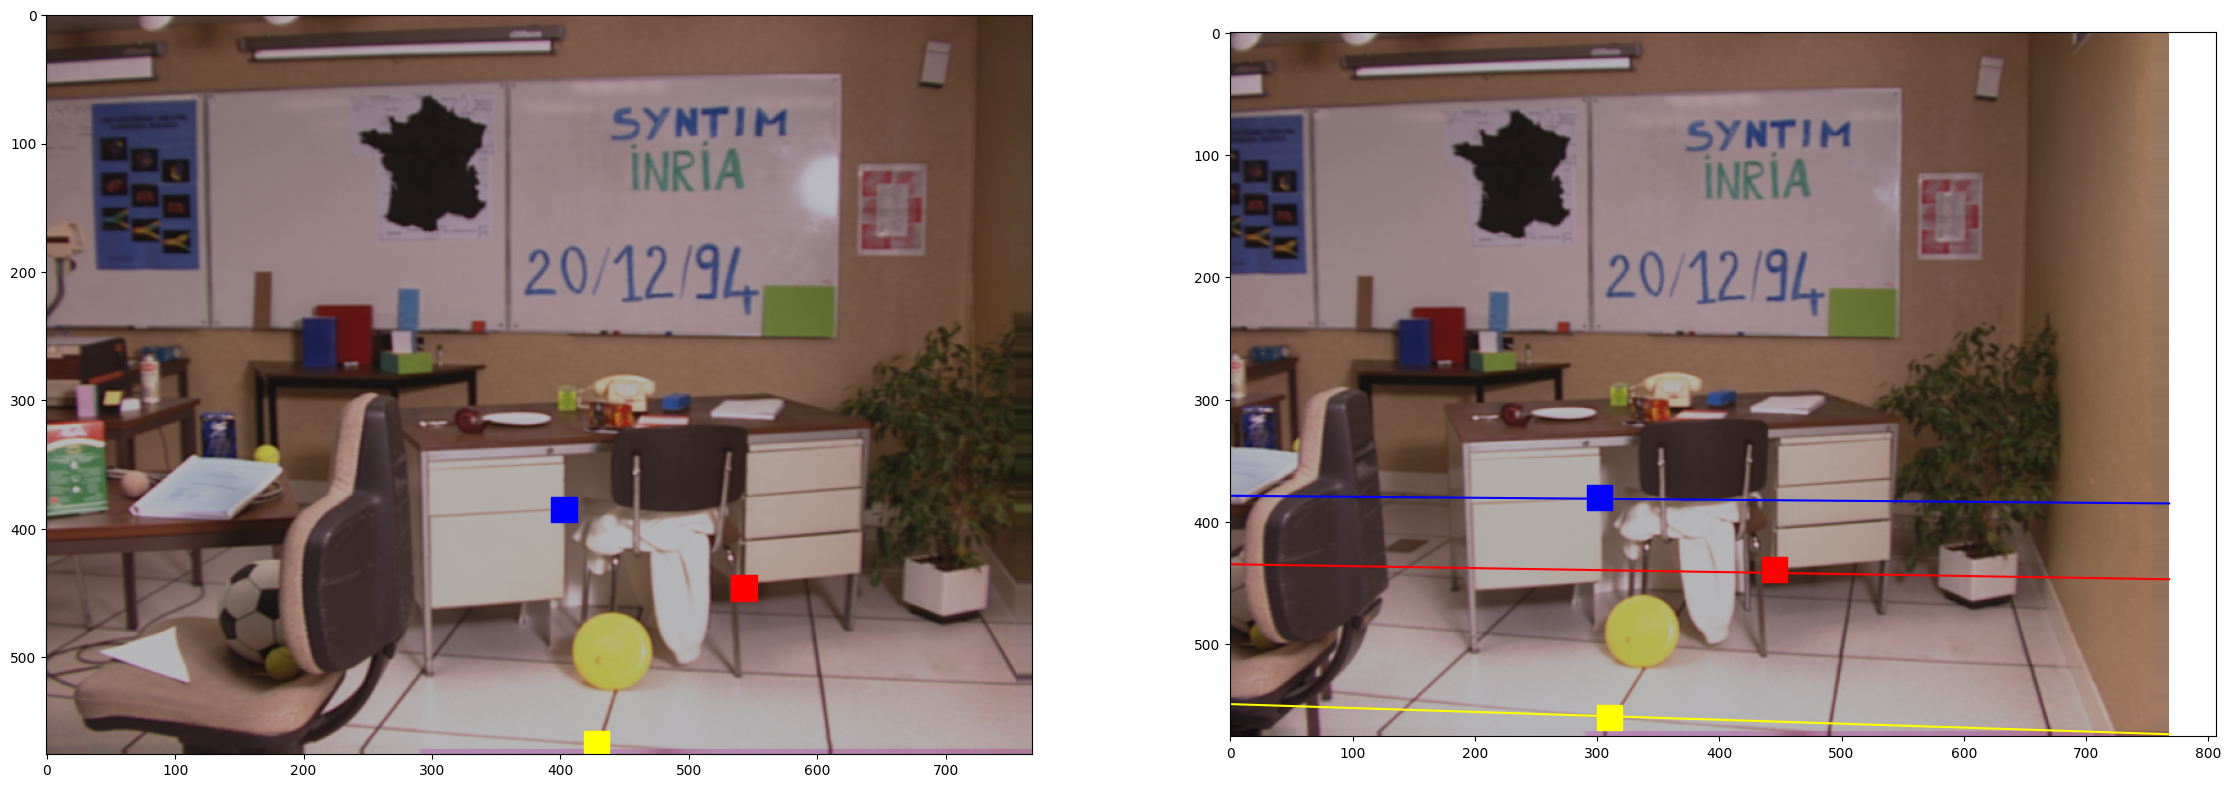

In [138]:
# Store your three points in image 1 in variable xchosen1
# Store the corresponding epipolar lines in variable epi_lines

# You can modify the code to display the figures, to highlight the corresponding point in image 2.
#    You will have to find the pixel co-ordinates of the
#    corresponding point in image 2 manually, as we are explicitly not choosing inliers (find the real matching point
#    and not the one your code outputs). The epipolar lines should
#    pass close by or through these points.
#

F_LM_approx = np.linalg.inv(K2.T) @ E_LM @ np.linalg.inv(K1) 
xchosen1 = np.array([[543, 403, 428],[446, 385, 567]]) # identify outliers in image 1
xchosen2 = np.array([[445, 302, 310],[439, 380, 560]]) # identify correspondances in image 2
xchosen1_homo = homogenize(xchosen1)
xchosen2_homo = homogenize(xchosen2)
epi_lines = F_LM_approx @ xchosen1_homo
print(epi_lines.shape, xchosen1_homo.shape, xchosen2_homo.shape)

# display the figures
plt.figure(figsize=(28,16))
ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)
ax1.imshow(I1)
ax2.imshow(I2)
im_height, im_width = I1.shape[:2]
x_ax = np.linspace(0, im_width, im_width*10)
colors = ['red', 'blue', 'yellow']
for i in range(xchosen1.shape[1]):
    a, b, c = epi_lines[:, i]
    xx, yy = [], []
    for xval in x_ax:
        yval = -(a/b)*xval - c/b
        if yval > 0 and yval < im_width:
            xx.append(xval)
            yy.append(yval)
    x1,y1 = xchosen1[:,i]
    x2,y2 = xchosen2[:,i]
    ax1.add_patch(patches.Rectangle((x1-w/2,y1-w/2),w,w, fill=True, color=colors[i]))
    ax2.plot(xx,yy,'-r', color=colors[i])
    ax2.add_patch(patches.Rectangle((x2-w/2,y2-w/2),w,w, fill=True, color=colors[i]))
plt.show()

I manually choose three outlier cornors from image 1 to map to image 2 using the estimated essential matrix. 

It turns out that the qualitative accuracy is satisfactory because the epipolar lines ($l_i^{\prime}$ s indicated by lines with different colors) in image 2 can all pass through the corresponding point patches (patches of $x_i^{\prime}$ s indicated by the squares) in image 2 with the same color. 

However, when we look at the cornors instead of patches, we see that those epipolar lines can't exactly pass the mapped cornor points in image 2. Perhaps it's because the outliers are a bit far from the inliers in terms of the Euclidean distance, and hence the model (the essential matrix built using only the inliers) didn't capture enough information from them.